In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [114]:
plt.rcParams['figure.figsize'] = (15,5)

In [115]:
data = pd.read_csv('data.csv')
print(data.shape)
data.head()

(8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Variable Description
* Item_Identifier - Id продукта
* Item_Weight - Вес продукта
* Item_Fat_Content - Содержание жира в продукте
* Item_Visibility - %полок, отведенный под наш продукт в конкретном магазине
* Item_Type - Категория продукта
* Item_MRP - Максимальная цена продажи продукта
* Outlet_Identifier - Идентификатор магазина
* Outlet_Establishment_Year - Год открытия магазина
* Outlet_Size - Площадь магазина
* Outlet_Location_Type - Тип города, в котором расположен магазин
* Outlet_Type - Признак является ли магазин продуктовым или супермаркетом
* Item_Outlet_Sales - Продажи продукта в конкретном магазине. Именно ее и надо предсказывать

In [116]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Item_Outlet_Sales',1),
                                                   data['Item_Outlet_Sales'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6392, 11), (2131, 11), (6392,), (2131,))

In [117]:
train_data = X_train.copy()
train_data['Item_Outlet_Sales'] = y_train
test_data = X_test.copy()
test_data['Item_Outlet_Sales'] = y_test

# NaNs

In [162]:
s = train_data.isna().sum()
s = s[s>0]
s

Item_Weight    1092
Outlet_Size    1799
dtype: int64

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


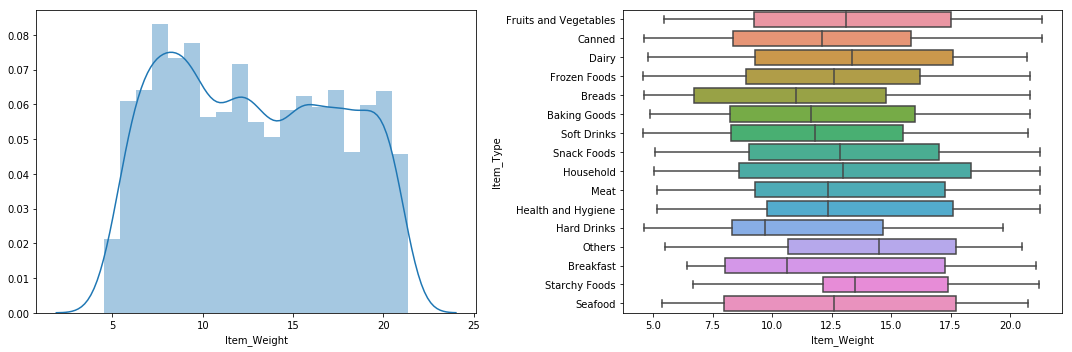

In [173]:
plt.subplot(121)
sns.distplot(train_data['Item_Weight'].dropna())

plt.subplot(122)
sns.boxplot(y='Item_Type',x='Item_Weight', data=train_data)

plt.tight_layout()
plt.show()

Вес всех продуктов распределён равномерно. Но интуитивно, вес продукта должен коррелировать с его типом: хлеб это, мясо или напиток. Поэтому заполним пропуски средним значением веса по типу продукта

In [181]:
d = train_data.groupby("Item_Type")['Item_Weight'].mean().to_dict()
train_data['Item_Weight'] = train_data['Item_Weight'].fillna(train_data['Item_Type'].apply(lambda x: d[x]))
test_data['Item_Weight'] = test_data['Item_Weight'].fillna(test_data['Item_Type'].apply(lambda x: d[x]))

Аналогично, размер магазина должен коррелировать с его типом

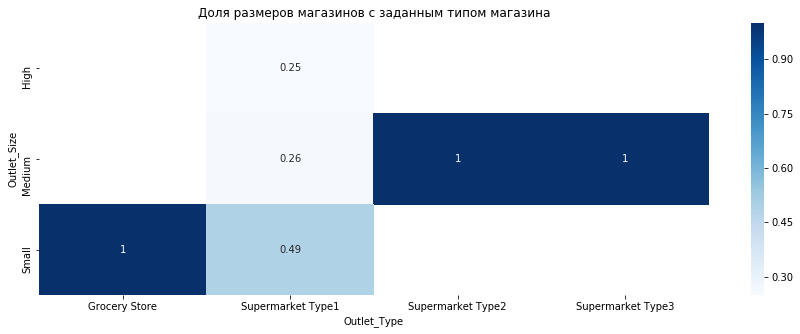

In [204]:
cds = train_data.pivot_table(index='Outlet_Size',columns='Outlet_Type',values='Outlet_Identifier',aggfunc='count')
cds = cds/cds.sum(0)
sns.heatmap(cds, cmap='Blues', annot=True)
plt.title('Доля размеров магазинов с заданным типом магазина');

Исходя из графика, самые вероятные варианты размера магазина:

In [207]:
d = {'Grocery Store':'Small',
     'Supermarket Type1':'Small',
     'Supermarket Type2':'Medium',
     'Supermarket Type3':'Medium',
    }
train_data['Outlet_Size'] = train_data['Outlet_Size'].fillna(train_data['Outlet_Type'].apply(lambda x: d[x]))
test_data['Outlet_Size'] = test_data['Outlet_Size'].fillna(test_data['Outlet_Type'].apply(lambda x: d[x]))

# EDA

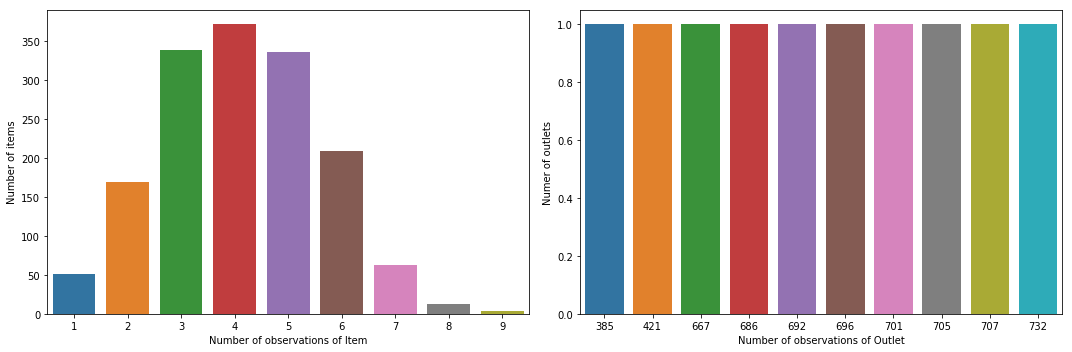

In [118]:
plt.subplot(121)
s = train_data['Item_Identifier'].value_counts().value_counts().sort_index()
sns.barplot(x=s.index, y=s.values)
plt.xlabel('Number of observations of Item')
plt.ylabel('Number of items')

plt.subplot(122)
s = train_data['Outlet_Identifier'].value_counts().value_counts().sort_index()
sns.barplot(x=s.index, y=s.values)
plt.xlabel('Number of observations of Outlet')
plt.ylabel('Numer of outlets')

plt.tight_layout()
plt.show()

В данных очень мало уникальных магазинов и продуктов - поэтому их можно определённым образом использовать в построении модели

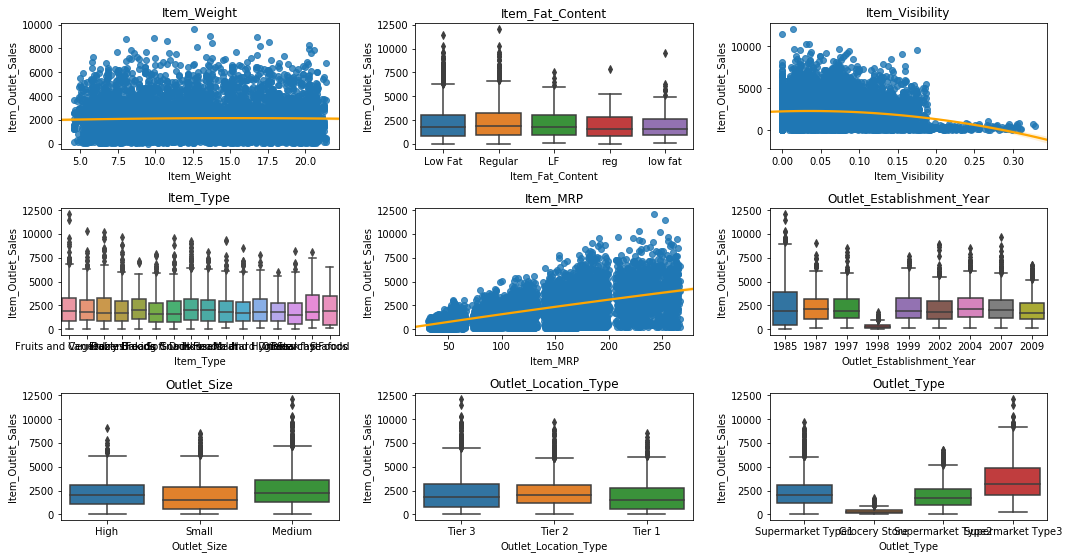

In [119]:
feats = list(data.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'],1).columns)
plt.figure(figsize=(15,10))
for idx, f in enumerate(feats):
    plt.subplot(len(feats)//3+1, 3, idx+1)
    if train_data[f].nunique()<30:
        sns.boxplot(x=f, y='Item_Outlet_Sales', data=train_data)
    else:
        sns.regplot(x=f, y='Item_Outlet_Sales', data=train_data, line_kws={'color':'orange'}, order=2)
    plt.title(f)

plt.tight_layout()
plt.show()

Что странного и интересного:
* Продукты, под которые отведено много полок плохо продаются. Это очень контринтуитивно
* Чем больше цена - тем больше продаж. Опять, очень странная зависимость
* Магазины 1998 года плохо продают товары. Скорее всего это просто выброс в данных
* Большой разброс продаж приходится на типы магазинов. Нужно посмотреть поподробнее
* Значения жирности продукта можно закодировать числами оставив между ними отношения порядка. То же с outlet_size. С outlet_location_type и outlet_type всё не так просто.
* Много значений жирности дублируют друг друга
* Остальные параметры не показывают ничего интересного

## Item Visibility

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

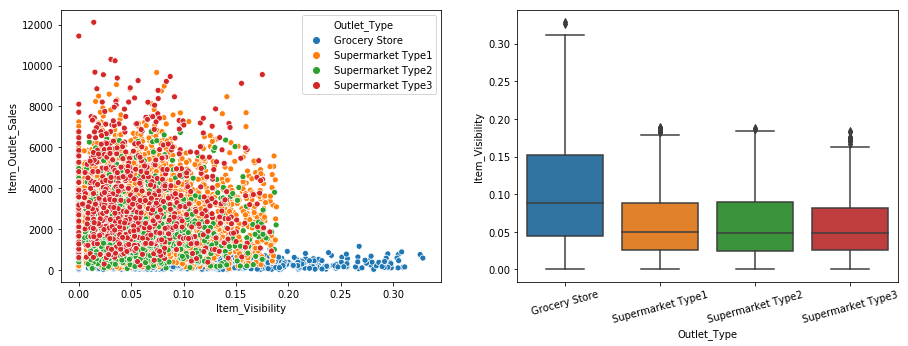

In [123]:
plt.subplot(121)
sns.scatterplot(x='Item_Visibility', y='Item_Outlet_Sales', data=train_data.sort_values('Outlet_Type'), hue='Outlet_Type')

plt.subplot(122)
sns.boxplot(x='Outlet_Type',y='Item_Visibility', data=train_data.sort_values('Outlet_Type'))
plt.xticks(rotation=15)

Товары, для которых отведено много полок продаются плохо по той причине, что они продаются в продуктовых магазинах. Поэтому признак деления на типы магазинов уже должен показать такую зависимость. Но лучше добавить собственный бинарных флаг, выше порога которого все товары продаются только в grocery.

In [124]:
t = train_data[train_data['Outlet_Type']!='Grocery Store']['Item_Visibility'].max()
print(t)
train_data['Big_Visibility_Flag'] = train_data['Item_Visibility']>t
test_data['Big_Visibility_Flag'] = test_data['Item_Visibility']>t

0.188619537


## Item MRP

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


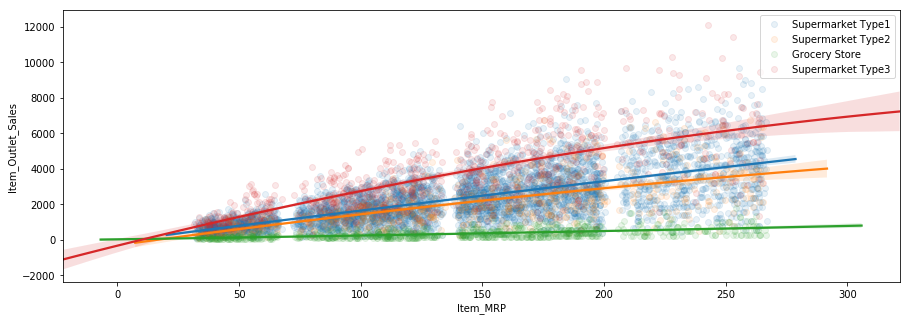

In [125]:
for v in data['Outlet_Type'].drop_duplicates().values:
    sns.regplot(x='Item_MRP',y='Item_Outlet_Sales',data=train_data[data['Outlet_Type']==v],
                scatter_kws={'alpha':0.1}, label=v, order=2)
plt.legend()
plt.show()

Товары продаются по разному в разных типах магазинов. Но все равно везде выполняется правило: чем выше цена, тем выше продажи. Хотя по законам спроса и предложения зависимость должна быть более похожа на параболу.

Тем не менее, вычислим коэффициенты каждой прямой

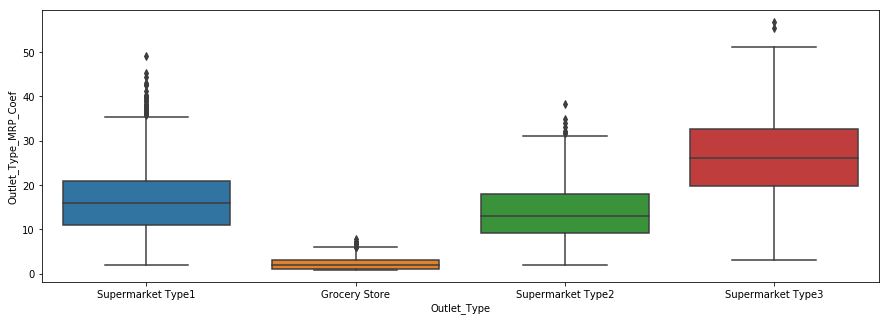

In [130]:
cds = train_data.copy()
cds['Outlet_Type_MRP_Coef'] = cds['Item_Outlet_Sales']/cds['Item_MRP']
sns.boxplot(x='Outlet_Type', y='Outlet_Type_MRP_Coef', data=cds)
d = cds.groupby('Outlet_Type')['Outlet_Type_MRP_Coef'].mean().to_dict()
train_data['Outlet_Type_MRP_Coef'] = train_data['Outlet_Type'].apply(lambda x: d[x])
test_data['Outlet_Type_MRP_Coef'] = test_data['Outlet_Type'].apply(lambda x: d[x])

# Item Type

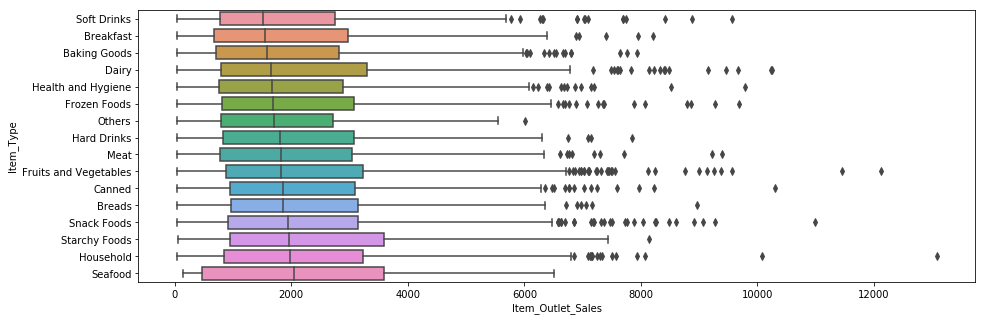

In [133]:
d = data.groupby('Item_Type')['Item_Outlet_Sales'].median().to_dict()
cds = data.copy()
cds['Mean_Sales_Per_Type'] = cds['Item_Type'].apply(lambda x: d[x])
cds = cds.sort_values('Mean_Sales_Per_Type')
sns.boxplot(y='Item_Type', x='Item_Outlet_Sales', data=cds);

Типы продуктов можно объединить по разделам: напитки, для дома, выпечка, быстрое приготовление и т.п. Но можно найти множество разных вариантов объединений - здесь нет какого-либо правильного ответа.

## Outlet Establishment year

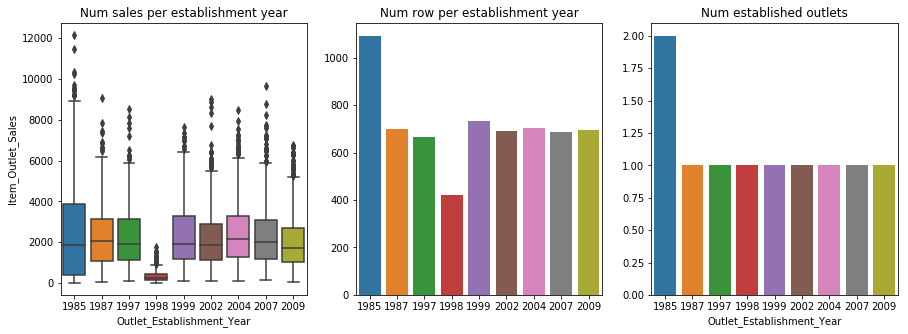

In [146]:
plt.subplot(131)
sns.boxplot(x='Outlet_Establishment_Year', y='Item_Outlet_Sales', data=train_data)
plt.title('Num sales per establishment year')

plt.subplot(132)
s = train_data['Outlet_Establishment_Year'].value_counts().sort_index()
sns.barplot(x=s.index, y=s.values)
plt.title('Num row per establishment year')

plt.subplot(133)
s = train_data.groupby('Outlet_Establishment_Year')['Outlet_Identifier'].nunique().sort_index()
sns.barplot(x=s.index, y=s.values)
plt.title('Num established outlets')


plt.show()

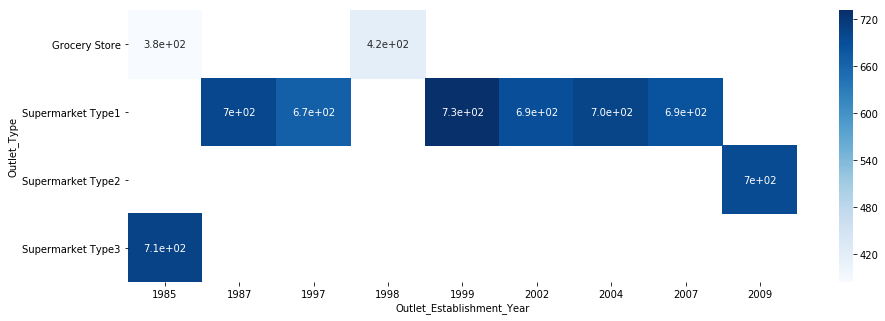

In [151]:
cds = train_data.pivot_table(index='Outlet_Type',columns='Outlet_Establishment_Year',
                       values='Outlet_Identifier', aggfunc='count')
sns.heatmap(cds, cmap='Blues', annot=True);

Причина низких продаж в магазинах, открытых в 1998 году - в том, что они относятся к Grocery Store

## Item Fat Content

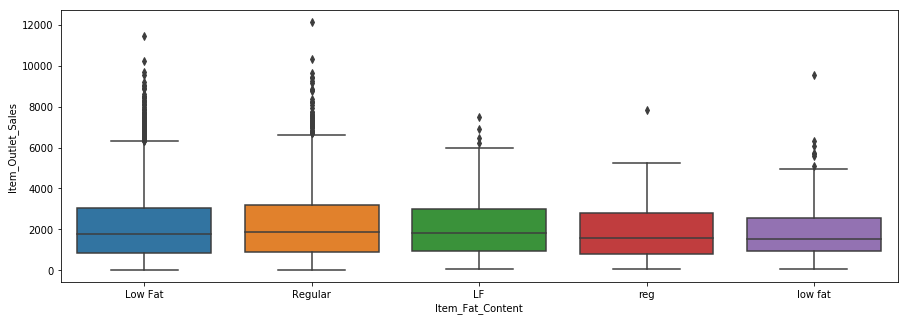

In [212]:
sns.boxplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=train_data)

Есть всего 2 уникальных значений жирности продукта. Преобразуем переменную в бинарный признак

In [213]:
train_data['Regular_Fat_Flag'] = train_data['Item_Fat_Content'].isin(['Regular','reg'])
test_data['Regular_Fat_Flag'] = test_data['Item_Fat_Content'].isin(['Regular','reg'])

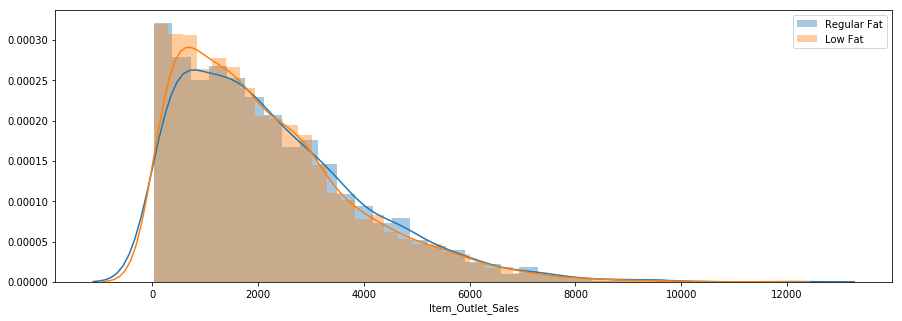

In [219]:
sns.distplot(train_data[train_data['Regular_Fat_Flag']==True]['Item_Outlet_Sales'], label='Regular Fat')
sns.distplot(train_data[train_data['Regular_Fat_Flag']==False]['Item_Outlet_Sales'], label='Low Fat')
plt.legend();

Данные почти не отличаются друг от друга. Но они ещё могут проявить себя при взаимодействии с другими признаками.

## Log

Целевая переменная сильно скошена влево и распределена примерно по логнормальному закону. Поэтому её лучше прологарифмировать и получить нечто похожее на нормальное распределение

In [266]:
train_data['Item_Outlet_Sales_log'] = np.log1p(train_data['Item_Outlet_Sales'])
test_data['Item_Outlet_Sales_log'] = np.log1p(test_data['Item_Outlet_Sales'])

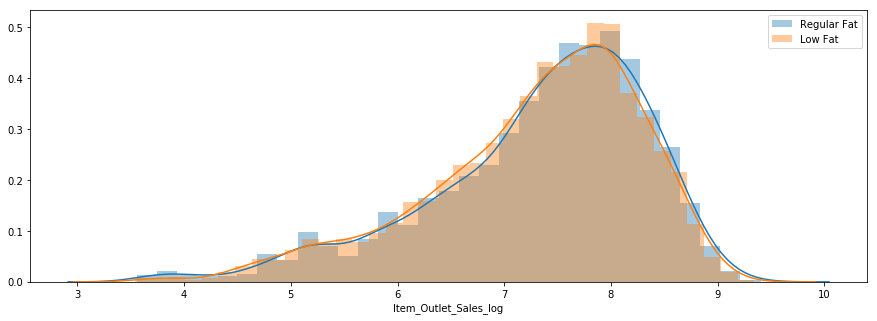

In [268]:
sns.distplot(train_data[train_data['Regular_Fat_Flag']==True]['Item_Outlet_Sales_log'], label='Regular Fat')
sns.distplot(train_data[train_data['Regular_Fat_Flag']==False]['Item_Outlet_Sales_log'], label='Low Fat')
plt.legend();

## Categorial encoding

In [338]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

Ordinal Encoding

In [232]:
d = {'Small':0, 'Medium':1, 'High':2}
train_data['Outlet_Size_Enc'] = train_data['Outlet_Size'].apply(lambda x: d[x])
test_data['Outlet_Size_Enc'] = test_data['Outlet_Size'].apply(lambda x: d[x])

In [353]:
for f in ['Item_Type', 'Outlet_Location_Type','Outlet_Type', 'Item_Identifier','Outlet_Identifier']:
    le = LabelEncoder()
    train_data[f+'_Enc'] = le.fit_transform(train_data[f])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    test_data[f+'_Enc'] = [le_dict.get(x,-1) for x in test_data[f] ]#le.transform(test_data[f],)

Mean Encodings

In [340]:
for f in ['Item_Identifier','Item_Type','Outlet_Identifier',
          'Outlet_Size','Outlet_Location_Type','Outlet_Type']:
    d = train_data.groupby(f)['Item_Outlet_Sales'].mean().to_dict()
    m = train_data['Item_Outlet_Sales'].mean()
    train_data[f+'_mean_enc'] = train_data[f].apply(lambda x: d[x])
    test_data[f+'_mean_enc'] = test_data[f].apply(lambda x: d.get(x,m))

One Hot Encodings

In [245]:
for f in ['Outlet_Location_Type','Outlet_Location_Type','Outlet_Type','Item_Type']:
    for v in train_data[f].unique():
        train_data[f+'__'+str(v)] = train_data[f]==v
        test_data[f+'__'+str(v)] = test_data[f]==v

# Напоследок проверим корреляцию между признаками

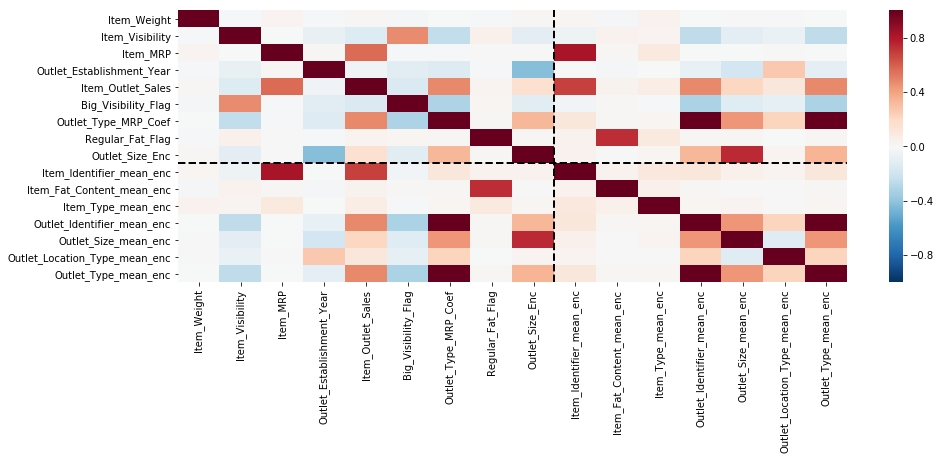

In [260]:
cds = train_data[[x for x in train_data.columns if '__' not in x]].corr()
sns.heatmap(cds, cmap='RdBu_r', vmin=-1, vmax=1)
for x in [9]:
    plt.axvline(x, linestyle='--', color='black', linewidth=2)
    plt.axhline(x, linestyle='--', color='black', linewidth=2)

# 

Многие признаки сильно скоррелированы между собой. Особенно это заметно между mean_encoder'ами для магазинов

# Выбор метрики

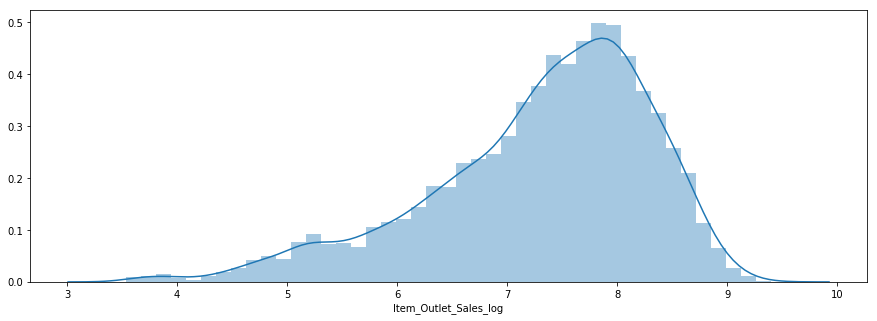

In [269]:
sns.distplot(train_data['Item_Outlet_Sales_log'])

Mae. А что мудрить? Ну ил r2

# Построение модели

In [323]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import Pool, CatBoostRegressor
from xgboost import XGBRFRegressor

In [298]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [314]:
res_ds = pd.DataFrame(columns=['name','mae_train','mae_test','r2_train','r2_test','features'])

In [315]:
def add_model_result(model, model_name, res_ds, train_data, test_data, feats, y_feat='Item_Outlet_Sales_log'):
    X_train = train_data[feats]
    X_test = test_data[feats]
    y_train, y_test = train_data[y_feat], test_data[y_feat]
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    res = {'name':model_name,
           'mae_train': mean_absolute_error(y_train, train_preds),
           'mae_test': mean_absolute_error(y_test, test_preds),
           'r2_train': r2_score(y_train, train_preds),
           'r2_test': r2_score(y_test, test_preds),
           'features':','.join(feats)}
    return res_ds.append(res, ignore_index=True)

In [316]:
lr_feats = [x for x in train_data if '__' in x] + \
 ['Item_Weight', 'Item_Visibility', 'Item_MRP',
  'Outlet_Establishment_Year', 'Big_Visibility_Flag', 'Outlet_Type_MRP_Coef',
  'Regular_Fat_Flag', 'Outlet_Size_Enc',
  'Item_Identifier_mean_enc','Item_Fat_Content_mean_enc','Item_Type_mean_enc',
  'Outlet_Identifier_mean_enc','Outlet_Location_Type_mean_enc'
 ]
y_feat = 'Item_Outlet_Sales_log'

In [317]:
lr = Ridge()
lr.fit(train_data[lr_feats],train_data[y_feat])
res_ds = add_model_result(lr, 'ridge_base', res_ds, train_data, test_data, lr_feats)

In [326]:
train_data.drop(cb_feats,1).columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Big_Visibility_Flag',
       'Outlet_Type_MRP_Coef', 'Regular_Fat_Flag', 'Outlet_Size_Enc',
       'Item_Identifier_mean_enc', 'Item_Fat_Content_mean_enc',
       'Item_Type_mean_enc', 'Outlet_Identifier_mean_enc',
       'Outlet_Size_mean_enc', 'Outlet_Location_Type_mean_enc',
       'Outlet_Type_mean_enc', 'Outlet_Location_Type__Tier 3',
       'Outlet_Location_Type__Tier 2', 'Outlet_Location_Type__Tier 1',
       'Outlet_Type__Supermarket Type1', 'Outlet_Type__Grocery Store',
       'Outlet_Type__Supermarket Type2', 'Outlet_Type__Supermarket Type3',
       'Item_Type__Fruits and Vegetables', 'Item_Type__Canned',
       'Item_Type__Dairy', 'Item_Type__Frozen Foods', 'Item_Type__Breads',
       'Item_Type__Baking Goods', 'Item_Type__Soft

In [329]:
cb_feats = ['Item_Identifier','Item_Weight','Item_Visibility','Item_Type','Item_MRP',
           'Outlet_Identifier','Outlet_Establishment_Year','Outlet_Size','Outlet_Location_Type',
           'Outlet_Type','Big_Visibility_Flag','Outlet_Type_MRP_Coef','Regular_Fat_Flag']
cat_feats = ['Item_Identifier','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type',
            'Outlet_Type']
train_pool = Pool(train_data[cb_feats], train_data[y_feat], cat_features=cat_feats)

In [333]:
cb = CatBoostRegressor()
cb.fit(train_pool, verbose=False, plot=True)
res_ds = add_model_result(cb, 'catboost_base', res_ds, train_data, test_data, cb_feats)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [342]:
train_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Big_Visibility_Flag',
       'Outlet_Type_MRP_Coef', 'Regular_Fat_Flag', 'Outlet_Size_Enc',
       'Item_Identifier_mean_enc', 'Item_Fat_Content_mean_enc',
       'Item_Type_mean_enc', 'Outlet_Identifier_mean_enc',
       'Outlet_Size_mean_enc', 'Outlet_Location_Type_mean_enc',
       'Outlet_Type_mean_enc', 'Outlet_Location_Type__Tier 3',
       'Outlet_Location_Type__Tier 2', 'Outlet_Location_Type__Tier 1',
       'Outlet_Type__Supermarket Type1', 'Outlet_Type__Grocery Store',
       'Outlet_Type__Supermarket Type2', 'Outlet_Type__Supermarket Type3',
       'Item_Type__Fruits and Vegetables', 'Item_Type__Canned',
       'Item_Type__Dairy', 'Item_Type__Frozen Foods', 'Item_Type__Breads',
       'Item_Type__Baking Goods', 'Item_Type__Soft

In [358]:
xgb_feats = ['Item_Identifier_Enc','Item_Weight','Item_Visibility','Item_Type_enc','Item_MRP',
           'Outlet_Identifier_Enc','Outlet_Establishment_Year','Outlet_Size_Enc','Outlet_Location_Type_Enc',
           'Outlet_Type_Enc','Big_Visibility_Flag','Outlet_Type_MRP_Coef','Regular_Fat_Flag',
            'Item_Identifier_mean_enc', 'Item_Fat_Content_mean_enc','Item_Type_mean_enc',
             'Outlet_Identifier_mean_enc', 'Outlet_Location_Type_mean_enc',]

In [359]:
xgb = XGBRFRegressor()
xgb.fit(train_data[xgb_feats], train_data[y_feat])
res_ds = add_model_result(xgb, 'xgboost_base', res_ds, train_data, test_data, xgb_feats)

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[01:27:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [361]:
rf_feats = xgb_feats

In [362]:
rf = RandomForestRegressor()
rf.fit(train_data[rf_feats], train_data[y_feat])
res_ds = add_model_result(rf, 'rf_base', res_ds, train_data, test_data, rf_feats)

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [366]:
svr_feats = lr_feats

In [367]:
svr = SVR()
svr.fit(train_data[svr_feats], train_data[y_feat])
res_ds = add_model_result(svr, 'svr_base', res_ds, train_data, test_data, svr_feats)

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [368]:
res_ds

,name,mae_train,mae_test,r2_train,r2_test,features
0,ridge_base,0.387134,0.460973,0.753819,0.675533,"Outlet_Location_Type__Tier 3,Outlet_Location_T..."
1,catboost_base,0.390853,0.405196,0.748715,0.741129,"Item_Identifier,Item_Weight,Item_Visibility,It..."
2,xgboost_base,0.398498,0.489597,0.744889,0.630863,"Item_Identifier_Enc,Item_Weight,Item_Visibilit..."
3,rf_base,0.164209,0.492789,0.949332,0.622998,"Item_Identifier_Enc,Item_Weight,Item_Visibilit..."
4,svr_base,0.237406,0.809757,0.799409,-0.013870,"Outlet_Location_Type__Tier 3,Outlet_Location_T..."


## Stacking

In [489]:
models = [lr, cb, xgb, rf, svr]
feats = [lr_feats, cb_feats, xgb_feats, rf_feats, svr_feats]

In [490]:
X_1, X_2, y_1, y_2 = train_test_split(train_data.drop(y_feat,1), train_data[y_feat])

In [491]:
pool_1 = Pool(X_1[cb_feats], y_1, cat_features=cat_feats)
pool_2 = Pool(X_2[cb_feats], y_2, cat_features=cat_feats)
pool_test = Pool(test_data[cb_feats], y_test, cat_features=cat_feats)

In [492]:
from tqdm import tqdm_notebook

In [503]:
p_testp-p

ValueError: operands could not be broadcast together with shapes (2131,) (1598,) 

In [501]:
p_test.shape

(2131,)

In [497]:
p_test

array([7.41042054, 7.41042054, 7.41042054, ..., 7.41042054, 7.41040652,
       7.41042054])

In [502]:
p.shape

(1598,)

In [451]:
preds_med = []
preds_test = []
for m,fs in tqdm_notebook(zip(models, feats), total=len(models)):
    if type(m)==CatBoostRegressor:
        m.fit(pool_1, verbose=False, plot=False)
        p = m.predict(pool_2)
        p_test = m.predict(pool_test)
    else:
        m.fit(X_1[fs], y_1)
        p = m.predict(X_2[fs])
        p_test = m.predict(test_data[fs])
    preds_med.append(p)
    preds_test.append(p_test)

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:57:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [452]:
X_med = np.vstack(preds_med).T
preds_test = np.vstack(preds_test).T

In [453]:
lr_ens = Ridge()
lr_ens.fit(X_med,y_2)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [454]:
cols = [f'model_{x}' for x in range(len(models))]

In [466]:
med_data = pd.DataFrame(X_med, columns=cols)
med_data[y_feat] = y_2.values

med_test_data = pd.DataFrame(preds_test, columns=cols)
med_test_data[y_feat] = y_test.values

In [471]:
res_ds = add_model_result(lr_ens, 'stacked_base', res_ds, med_data, med_test_data, cols)

In [472]:
res_ds

,name,mae_train,mae_test,r2_train,r2_test,features
0,ridge_base,0.387134,0.460973,0.753819,0.675533,"Outlet_Location_Type__Tier 3,Outlet_Location_T..."
1,catboost_base,0.390853,0.405196,0.748715,0.741129,"Item_Identifier,Item_Weight,Item_Visibility,It..."
2,xgboost_base,0.398498,0.489597,0.744889,0.630863,"Item_Identifier_Enc,Item_Weight,Item_Visibilit..."
3,rf_base,0.164209,0.492789,0.949332,0.622998,"Item_Identifier_Enc,Item_Weight,Item_Visibilit..."
4,svr_base,0.237406,0.809757,0.799409,-0.013870,"Outlet_Location_Type__Tier 3,Outlet_Location_T..."
5,stacked_base,0.372775,2160.786661,0.773718,-1.541125,"model_0,model_1,model_2,model_3,model_4"
